<a href="https://colab.research.google.com/github/hatopopvr/MyBSCloud/blob/main/MyBSCloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MyBSCloud

<b>概要</b>
- ScoreSaberのデータを使用して自分のプレイを構成するmapperやartistのwordcloud画像を作成するツールです。
- ワードの出現数ベース(背景白)とPPWeightベース(背景黒)の2種類のWordCloudを出力します。
- マスク画像を使用することで自分らしいwordcloud画像を作成することもできます。
- Google Driveの認証はScoreSaberのプレイデータを保存することのみに使います。(ScoreSaber APIへのアクセス負荷減のため)

- 作成するwordcloudは日本語には対応していません。

<b>データ元</b>
- ScoreSaber Public API - [doc](https://docs.scoresaber.com/)  

<b>このノートの作者</b>
- hatopop ([@hatopop_vr](https://twitter.com/hatopop_vr))

<b>Libraries</b>

このノートブックでは以下のサードパーティ製のライブラリを使用しています。

- [**pandas**](https://pandas.pydata.org/): データの操作と分析のためのライブラリ。
- [**numpy**](https://numpy.org/): 数値計算のためのライブラリ。
- [**matplotlib**](https://matplotlib.org/) & [**seaborn**](https://seaborn.pydata.org/): データの可視化のためのライブラリ。
- [**tqdm**](https://tqdm.github.io/): 進捗バーを表示するためのライブラリ。
- [**PIL (Pillow)**](https://pillow.readthedocs.io/en/stable/): 画像処理のためのライブラリ。
- [**wordcloud**](https://amueller.github.io/word_cloud/): ワードクラウドの生成のためのライブラリ。
- [**openai**](https://github.com/openai/openai): OpenAI APIを利用するためのライブラリ。


In [1]:
#@title ※※※ 入力情報 ※※※

#@markdown 以下のデータを入力してください。 { display-mode: "form" }

#@markdown ---
#@markdown <h4>Input Data</h4>

#@markdown <font size="2">`player_id` : ScoreSaberのPlayerIDです。変更必須。<br/></font>  
player_id =  76561198412839195#@param {type:"number"}

#@markdown <font size="2">`google_drive_mount_path` ：GoogleDriveのマウント先です。変更不要。</font><br/> 
google_drive_mount_path = "/content/drive" #@param {type:"string"}

#@markdown <font size="2">`google_drive_dir_path` : GoogleDrive内の保存先です。必要に応じて変更してください。</font> 
google_drive_dir_path = "/MyDrive/MyBeatSaberAnalysis/data" #@param {type:"string"}

#@markdown ---
#@markdown <h4>Setting</h4>

#markdown <font size="2">`saved_song_list_is_enable`:保存済の曲情報を使用するか。☑で使用。</font> 
saved_song_list_is_enable = True #param {type:"boolean"}
#@markdown <font size="2">`saved_player_score_is_enable`: 保存済のプレイ情報を使用するか。☑で使用。※差分ダウンロード。</font>
saved_player_score_is_enable = True #@param {type:"boolean"}
# #@markdown <font size="2">`acc_recalq_override_is_enable`: MaxScore,Accを再計算した値をMaxScore,Accに上書きするか。☑で使用。</font> 
# acc_recalq_override_is_enable = True #@param {type:"boolean"}
# #@markdown <font size="2">`beatleader_data_is_enable`: BeatLeaderのデータを取得するか。L/RのAccやReplayのリンクなど追加。☑で使用。</font> 
# beatleader_data_is_enable = True #@param {type:"boolean"}
# #@markdown <font size="2">`ranked_song_from_leaderboard_is_enable`: Ranked譜面クリア進捗用のレベル別譜面数をScoreSaberのLeaderBoardから取得し直すか。☑で使用。<br /></font>
# #@markdown <font size="2">※Ranked譜面の譜面数が正しく得られていない時のみ取得し直されます。</font>
# ranked_song_from_leaderboard_is_enable = True #@param {type:"boolean"}
#markdown <font size="2">`ss_plus_is_enable`: AccRank区分にSS+を使用するか。☑で使用。  </font><br /> 
ss_plus_is_enable = True #param {type:"boolean"}
#markdown <font size="2">`ss_plus_val`:SS+の設定値です。必要に応じて変更ください。範囲は91-99。  
ss_plus_val = 95 #param {type:"slider", min:91, max:99, step:1}
#@markdown <font size="2">`latest`:直近の成果として扱う対象の日数です。0は日本時間で今日と同じ日付。例)今日が5/9で1なら5/8以降のデータ。</font><br /> 
#@markdown <font size="2">※名称がlatestだったりRecentだったり混在してしまっていますが許してください。</font>
latest =  0#@param {type:"integer"}
#markdown <font size="2">`score_mode`:取得するスコアを選択します。`HigherScore`は`BaseScore`と`ModifieredScore`の高い方の値を採用します.</font>
score_mode = "HigherScore" #param ["BaseScore", "ModifieredScore", "HigherScore"]

# ------------------------
#@title Libraryの取得
# ------------------------
#markdown - Libraryの取得<br >
#markdown - timezoneの設定 (UTC->日本時間 Asia/Tokyo+9:00 ,tz_ja)
#markdown - google driveのマウント<br >

!pip install GitPython

import warnings
warnings.filterwarnings("ignore")
import os
import shutil
import pandas as pd
from pandas import json_normalize
import json
from datetime import datetime, timedelta
from dateutil import tz
import time
from tqdm import tqdm
import requests
import math
import git
from IPython.display import HTML, Javascript,Image, display, Markdown
from google.colab import drive, files
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import copy
from wordcloud import WordCloud, STOPWORDS
try:
    import openai
except:
    !pip install openai==0.27.0
    import openai
from collections import defaultdict


#-------------------------------
#@title Timezoneの変更
#-------------------------------
tz_ja = pd.Timestamp(datetime.now()).tz_localize('UTC').tz_convert('Asia/Tokyo')
#today_tz_ja = datetime_now_tz_ja.strftime("%Y.%m.%d")
print("取得日時:{}".format(tz_ja))

#-------------------------------
#@title Google Driveのマウント
#-------------------------------
drive.mount(google_drive_mount_path)

#-------------------------------
#@title 内部設定値
#-------------------------------
# データ元のURL
## song_data_zip_git_url: ScoreSaberの全曲情報のzip(json)のURLです。変更なければそのままで。 
song_data_zip_git_url = "https://github.com/andruzzzhka/BeatSaberScrappedData.git"
## ranked_excluded_data_git_url: ScoreSaberのRank譜面除外リスト(csv)のURLです。暫定的処置。 
ranked_excluded_data_git_url = "https://github.com/hatopopvr/ScoreSaberRankedExcludedMaps.git"
## rankedmapdata_url: BeatSaverデータのcsvのURLです。らっきょさんデータ。 
rankedmapdata_url = 'https://api.github.com/repos/rakkyo150/RankedMapData/releases'
# google drive内のdata置き場親フォルダ
data_path = r"{}{}".format(google_drive_mount_path, google_drive_dir_path)
# player情報の親フォルダ(data_pathの子フォルダ)
player_path = r"{}/players_data/{}".format(data_path, player_id)
## playerinfoの保存先
player_info_path = r"{}/player_info_{}.csv".format(player_path, player_id)
## playerのscore関連保存先
player_score_path = r"{}/scores_full_{}.csv".format(player_path, player_id)
player_ranked_path = r"{}/scores_ranked_{}.csv".format(player_path, player_id)
## playerのscore関連保存先
player_score_pickle_path = r"{}/scores_full_{}.pkl".format(player_path, player_id)
player_ranked_pickle_path = r"{}/scores_ranked_{}.pkl".format(player_path, player_id)
## 曲情報の保存関連
song_clone_path = r"/content/BeatSaberScrappedData"
song_zip_path = r"{}/combinedScrappedData.zip".format(song_clone_path)
song_json_path = r"{}/combinedScrappedData.json".format(data_path)
song_pickle_path = r"{}/combinedScrappedData.pkl".format(data_path)
## 曲情報の保存先
song_list_path = r"{}/song_list_full.csv".format(data_path)
song_ranked_path = r"{}/song_ranked.csv".format(data_path)

# song_playlist_path = r"{}/playlist_{}.json".format(data_path, datetime.now().strftime("%Y%m%d"))
# ランク除外関連パス
ranked_excluded_clone_dir_path = r"/content/ScoreSaberRankedExcludedMaps"
ranked_excluded_clone_csv_path = r"{}/RankedExcludedMaps.csv".format(ranked_excluded_clone_dir_path)
ranked_excluded_csv_path = r"{}/RankedExcludedMaps.csv".format(data_path)
# levelclearランク除外関連パス
#level_cleared_path = r"{}/level_cleared_{}.csv".format(data_path, player_id)
level_cleared_path = r"{}/level_cleared_{}.csv".format(player_path, player_id)

# playlistの保存
song_playlist_path = r"{}/playlists".format(data_path)
song_worst_playlist_path = r"{}/worst_playlist_{}.json".format(song_playlist_path, tz_ja.strftime("%Y%m%d"))
song_top_playlist_path = r"{}/top_playlist_{}.json".format(song_playlist_path, tz_ja.strftime("%Y%m%d"))

# # MｙBSCloudのmask画像の保存
# # player情報の親フォルダ(data_pathの子フォルダ)
# mybscloud_path = r"{}/mybscloud/{}".format(data_path, player_id)

# SS_plus設定値
ss_plus = "SS+{}".format(ss_plus_val)
ss_plus_rate = "SS+{}-Rate".format(ss_plus_val)
# その他 colab表示など設定
pd.options.display.precision = 2
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
page_count=100 #ScoreSaberの1ページあたりのページ数

# 出力最大高さ
def resize_colab_cell():
    display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))

get_ipython().events.register('pre_run_cell', resize_colab_cell)

#-------------------------------
#@title 列情報の設定
#-------------------------------
# Player Infoの記録用列 (TotalFC, RankedFCは別途結合)
cols_info =[
    "Pic"
    ,"name"
    ,"country"
    ,"pp"
    ,"rank"
    ,"countryRank"
    ,"role"
    ,"TotalScore"
    ,"RankedScore"
    ,"AveRankedAcc"
    ,"TotalPlay"
    ,"RankedPlay"
    ,"ReplayWatched"
    ,"ScoreDate"
    ,"TotalFC"
    ,"RankedFC"
    ,"TotalPlayRank"
    ,"TotalPlayJPRank" 
    ,"RankedPlayRank"
    ,"RankedPlayJPRank"
    ,"TotalScoreRank" 
    ,"TotalScoreJPRank"
    ,"RankedScoreRank"
    ,"RankedScoreJPRank" 
    ,"AveRankedAccRank"
    ,"AveRankedAccJPRank"
]

# Player Infoの表示用列 (TotalFC, RankedFCは別途結合)
cols_info_sort =[
    "Pic"
    ,"name"
    ,"country"
    ,"pp"
    ,"rank"
    ,"countryRank"
    ,"role"
    ,"TotalScore"
    ,"RankedScore"
    ,"AveRankedAcc"
    ,"TotalPlay"
    ,"RankedPlay"
    ,"TotalFC"
    ,"RankedFC"
    ,"ReplayWatched"
    ,"ScoreDateJa"
]

# リュナンさんのScoreSaberRanking表示用列(不使用)
cols_info_rank = [
    "TotalPlayRank"
    ,"TotalPlayJPRank" 
    ,"RankedPlayRank"
    ,"RankedPlayJPRank"
    ,"TotalScoreRank" 
    ,"TotalScoreJPRank"
    ,"RankedScoreRank"
    ,"RankedScoreJPRank" 
    ,"AveRankedAccRank"
    ,"AveRankedAccJPRank"
]

# summary用列
cols_summary =[
    "rank"
    ,"countryRank"
    ,"pp"
    ,"AveRankedAcc"
    ,"TotalPlay"
    ,"RankedPlay"
]

# SongList抜粋用列
cols_song =[
    "Cover"
    ,"Song"
    ,"Level"
    ,"LevelStr"
    ,"Stars"
    # ,"maxPP"
    # ,"maxScore"
    ,"Difficulty"
    # ,"Play"
    # ,"DailyPlay"
    ,"CreatedDateJa"
    ,"RankDateJa"
    ,"Bombs"
    ,"Notes"
    ,"Obstacles"
    ,"Njs"
    ,"NjsOffset"
    ,"Bpm"
    ,"Upvotes"
    #,"Downvotes"
    ,"Duration"
    ,"Ranked"
]

# Rank譜面除外リスト結合用列
cols_excluded = [
                 'Hash',
                 'Difficulty',
                 'RankedExcluded'
                 ]

# Score用列
cols_score =[
    "Cover"
    ,"Song"
    ,"Level"
    ,"Stars"
    ,"Acc"
    ,"AccRank"
    ,"FC"
    ,"Rank"
    ,"PP"
    ,"Miss"
    ,"Bad"
    ,"Combo"
    ,"Score"
    #,"Mode"
    ,"Difficulty"
    ,"Play"
    ,"DailyPlay"
    ,"Bpm"
    ,"Duration"
    ,"Notes"
    ,'Nps'
    ,"Njs"
    ,"Bombs"
    ,"Obstacles"
    ,"NjsOffset"
    ,'Upvotesratio' 
    ,"Upvotes"
    ,"Downvotes"
    ,"Ranked"
    ,"Days"
    ,"Months"
    ,"Tags"
    ,"Preview"
 ]

# Acc再計算用列
cols_recalq = [
    'Hash',
    'Cover',
    'SongName',
    'Difficulty', 'Stars', 
    'Ranked', 
    'Notes', 
    'Acc', 
    'AccRecalq', 
    'AccDiff',
    'AccRank', 
    'AccRankRecalq', 
    'MaxScore',
    'MaxScoreRecalq',
    'MaxScoreDiff',
    'Score', 
    'Miss', 
    'Combo',
    'RankDateJa',
    'CreatedDateJa', 
    'Preview'
]

# ScatterPlot用X-Y軸列
cols_xy = [
    "Stars"
    ,"Level"
    ,"Acc"
    ,"Rank"
    ,"PP"
    ,"Miss"
    ,"Bad"
    ,"Combo"
    ,"Score"
    ,"Play"
    ,"DailyPlay"
    ,"Days"
    ,"Months"
    ,"Bpm"
    ,"Duration"
    ,"Notes"
    ,'Nps'
    ,"Njs"
    ,"Bombs"
    ,"Obstacles"
    ,"NjsOffset"
    ,'Upvotesratio'
    ,"Upvotes"
    ,"Downvotes"
]

# RankedMap(BeatSaver)結合用列
cols_rankedmap = ['Hash', 
                  'Difficulty', 
                  'Upvotesratio',
                  'Nps', 
                  'Tags', 'Preview'
]

# ScatterPlot用カテゴリ
cols_cate = [
    "LevelStr"
    ,"Days"
    ,"DaysStr"
    ,"Months"
    ,"MonthsStr"
    ,"LatestStr"
    ,"Acc"
    ,"AccRank"
    ,"FC"
    ,"SongAuthor"
    ,"LevelAuthor"
]

# Worst-Top ScatterPlot用カテゴリ
cols_cate_wt = [
    "WorstTop"
    ,"LevelStr"
    ,"Days"
    ,"DaysStr"
    ,"Months"
    ,"MonthsStr"
    ,"LatestStr"
    ,"Acc"
    ,"AccRank"
    ,"FC"
    ,"SongAuthor"
    ,"LevelAuthor"
]

# Latest_history用の列
cols_latest_history = ['Cover', 'Song', 'Difficulty', 'Stars', 'Acc', 'AccRank', 'FC', 'Rank', 'PP',
       'Miss', 'Bad', 'Combo', 'Score']

#-------------------------------
#@title スタイルの設定
#-------------------------------

cover_image_size=70 #カバー,プロファイル画像のサイズ単位px
info_image_size=150 #Player画像のサイズ単位px

style_format = {
        "rank": "#{:,.0f}",
        "countryRank": "#{:,.0f}",
        "TotalScore": "{:,.0f}",
        "RankedScore": "{:,.0f}",
        "AveRankedAcc": "{:,.2f}%",
        "TotalPlay": "{:,.0f}",
        "TotalFC": "{:,.0f}",
        "RankedFC": "{:,.0f}",
        "ReplayWatched": "{:,.0f}",
        "Level": "{:,.0f}",
        "Stars": "{:,.2f}★",
        "Acc": "{:,.2f}%",
        "AccRecalq": "{:,.2f}%",
        "AccDiff": "{:,.2f}%",
        "MaxScore": "{:,.0f}",
        "MaxScoreRecalq": "{:,.0f}",
        "MaxScoreDiff": "{:,.0f}",
        "Score": "{:,.0f}",
        "Rank": "#{:,.0f}",
        "pp": "{:,.2f}pp",
        "PP": "{:,.2f}pp",
        "Miss": "{:,.0f}",
        "Bad": "{:,.0f}",
        "Combo": "{:,.0f}",
        "Score": "{:,.0f}",
        "Play": "{:,.0f}",
        "DailyPlay": "{:,.0f}",
        "Bpm": "{:,.0f}",
        "Duration": "{:,.0f}",
        "Notes": "{:,.0f}",
        "Nps": "{:,.2f}",
        "Njs": "{:,.0f}",
        "Bombs": "{:,.0f}",
        "Obstacles": "{:,.0f}",
        "NjsOffset": "{:,.2f}",
        "Upvotesratio": "{:,.2f}",
        "Upvotes": "{:,.0f}",
        "Downvotes": "{:,.0f}",
        "Days": "{:,.0f}",
        "Months": "{:,.0f}",
        "Song": "{:,.0f}",
        "RecentCleared": "{:,.0f}",
        "Cleared": "{:,.0f}",
        "NF": "{:,.0f}",
        "NotCleared": "{:,.0f}",
        "AlreadyCleared": "{:,.0f}",
        "NotClearedRate": "{:,.2f}%",
        "AlreadyClearedRate": "{:,.2f}%",
        "RecentClearedRate": "{:,.2f}%",
        "NFRate": "{:,.2f}%",
        "SSS": "{:,.0f}",
        ss_plus: "{:,.0f}",
        "SS": "{:,.0f}",
        "S": "{:,.0f}",
        "A": "{:,.0f}",
        "B": "{:,.0f}",
        "Other": "{:,.0f}",
        "SSS-Rate": "{:,.2f}%",
        "SS-Rate": "{:,.2f}%",
        ss_plus_rate: "{:,.2f}%",
        "S-Rate": "{:,.2f}%",
        "A-Rate": "{:,.2f}%",
        "B-Rate": "{:,.2f}%",
        "Other-Rate": "{:,.2f}%",
        "FC": "{:,.0f}",
        "RecentFC": "{:,.0f}",
        "AlreadyFC": "{:,.0f}",
        "NotFC": "{:,.0f}",
        "AlreadyFCRate": "{:,.2f}%",
        "RecentFCRate": "{:,.2f}%",
        "NotFCRate": "{:,.2f}%",
        "Song": "{:,.0f}",
        "TotalPlayRank": "#{:,.0f}",
        "TotalPlayJPRank": "#{:,.0f}",
        "RankedPlayRank": "#{:,.0f}",
        "RankedPlayJPRank": "#{:,.0f}",
        "TotalScoreRank": "#{:,.0f}",
        "TotalScoreJPRank": "#{:,.0f}",
        "RankedScoreRank": "#{:,.0f}",
        "RankedScoreJPRank": "#{:,.0f}",
        "AveRankedAccRank": "#{:,.0f}",
        "AveRankedAccJPRank": "#{:,.0f}",
     }

ss_plus = "SS+{}".format(ss_plus_val)
ss_plus_rate = "SS+{}-Rate".format(ss_plus_val)

style_worst_top = {
        "Level": "{:,.0f}",
        "Stars": "{:,.2f}★",
        "Acc": "{:,.2f}%",
        "Rank": "#{:,.0f}",
        "pp": "{:,.2f}pp",
        "PP": "{:,.2f}pp",
        "Miss": "{:,.0f}",
        "Bad": "{:,.0f}",
        "Combo": "{:,.0f}",
        "Score": "{:,.0f}",
        "Play": "{:,.0f}",
        "DailyPlay": "{:,.0f}",
        "Bpm": "{:,.0f}",
        "Duration": "{:,.0f}",
        "Notes": "{:,.0f}",
        "Nps": "{:,.2f}",
        "Njs": "{:,.0f}",
        "Bombs": "{:,.0f}",
        "Obstacles": "{:,.0f}",
        "NjsOffset": "{:,.2f}",
        "Upvotesratio": "{:,.2f}",
        "Upvotes": "{:,.0f}",
        "Downvotes": "{:,.0f}",
        "Days": "{:,.0f}",
        "Months": "{:,.0f}",
     }

def color_negative_red(val):
    color = 'red' if val < 0 else 'blue'
    return 'color: %s' % color

# Difficulty color
def color_difficulty(val):
    if val == "Easy":
        return 'color: #66BB6A; font-weight: bold;'
        color = "#66BB6A"
    elif val == "Normal":
        return 'color: #29B6F6; font-weight: bold;'
        color = "#29B6F6"
    elif val == "Hard":
        return 'color: #FB8C00; font-weight: bold;'
        color = "#FB8C00"
    elif val == "Expert":
        return 'color: #E53935; font-weight: bold;'
        color = "#E53935"
    elif val == "Expert+":
        return 'color: #8E24AA; font-weight: bold;'
        color = "#8E24AA"
    elif val == "ExpertPlus":
        return 'color: #8E24AA; font-weight: bold;'
        color = "#8E24AA"
    return 'color: %s' % color

# Acc Rank color
def color_acc_rank(val):
    if val == "SSS":
        return 'color: #00ffff; font-weight: bold;'
    elif ss_plus_is_enable and val == ss_plus:
        return 'color: #636EFA; font-weight: bold;'
    elif val == "SS":
        return 'color: #ff4500; font-weight: bold;'
    elif val == "S":
        return 'color: #ffaaff; font-weight: bold;'
    elif val == "A":
        return 'color: #ffcc66; font-weight: bold;'
        #color = "#eebb55"
    elif val == "B":
        return 'color: #cccc66; font-weight: bold;'
    else:
        return 'color: #666666; font-weight: bold;'
    # return 'color: %s' % color

# FC color
def color_fc(val):
    if val == "FC":
        color = "#23D160"
    else:
        color = "black"        
    return 'color: %s' % color

def color_fc(val):
    if val == "FC":
        return 'color: #23D160; font-weight: bold;'
    else:
        return 'color: black'


# Player Info Table Format
styles_info = [
    dict(selector="td", props=[("font-size", "130%"),
                               ("text-align", "center"),
                               ("padding-top", "0px"),
                               ("padding-bottom", "0px"),                              
                               ])
]

# Player Info Table Format
styles_data = [
    {"selector":"td", "props":[("padding-top", "0px"),
                               ("padding-bottom", "0px"),                              
                               ]},
    {"selector":"th", "props":[("padding-top", "0px"),
                               ("padding-bottom", "0px"),                              
                               ]},
]

#SS+95	SS+95-Rate FC

#-------------------------------
#@title 各種フォルダの作成
#-------------------------------
# 各種パスのディレクトリ作成
## データ大元のフォルダ作成
if os.path.exists(data_path) == False:
    print('MyBeatSaberAnalytics用のデータ格納フォルダをGoogle Driveに新規作成します。')
    print('データ格納フォルダ:{}'.format(data_path))     
    os.makedirs(data_path, exist_ok=True)
    print('作成が完了しました。')         

## データ大元のフォルダ作成
if os.path.exists(player_path) == False:
    old_player_info_path = r"{}/player_info_{}.csv".format(data_path, player_id)
    print('PlayerID:{}用のデータ格納フォルダを新規作成します。'.format(player_id))
    print('playerフォルダ:{}'.format(player_path))     
    print('作成が完了しました。')         
    os.makedirs(player_path, exist_ok=True)
    if os.path.isfile(old_player_info_path):
        print('データ引継ぎのため、player_infoｂのcsvファイルを上記フォルダに移動させます。')
        print('移動前:{}'.format(old_player_info_path))
        print('移動後:{}'.format(player_info_path))
        shutil.move(old_player_info_path, player_info_path)
        print('移動が完了しました。')

## プレイヤー用のフォルダ作成
if os.path.exists(song_playlist_path) == False:
    print('Playlist格納用のフォルダを新規作成します。')
    print('Playlist格納フォルダ:{}'.format(song_playlist_path))     
    os.makedirs(song_playlist_path, exist_ok=True)
    print('作成が完了しました。')       


# ## MyBSCloud用のフォルダ作成
# if os.path.exists(mybscloud_path) == False:
#     print('MyBSCloud格納用のフォルダを新規作成します。')
#     print('MyBSCloud格納用のフォルダ:{}'.format(mybscloud_path))     
#     os.makedirs(mybscloud_path, exist_ok=True)
#     print('作成が完了しました。')       


#-------------------------------
#@title Player情報の取得
#-------------------------------
#markdown Get Player Info (df_info)
url = r"https://scoresaber.com/api/player/{}/full".format(player_id)
response = requests.get(url)
res_data = response.json()
df_info = json_normalize(res_data)

#df_info["Pic"] = '<img src="'+df_info["profilePicture"]+'"/>'
df_info["Pic"] = '<img src="'+df_info["profilePicture"]+'" style="width:{}px;"/>'.format(info_image_size)
df_info["TotalScore"] = df_info["scoreStats.totalScore"]
df_info["RankedScore"] = df_info["scoreStats.totalRankedScore"]
df_info["AveRankedAcc"] = df_info["scoreStats.averageRankedAccuracy"]
df_info["TotalPlay"] = df_info["scoreStats.totalPlayCount"]
df_info["RankedPlay"] = df_info["scoreStats.rankedPlayCount"]
df_info["ReplayWatched"] = df_info["scoreStats.replaysWatched"]
df_info["ScoreDate"] = datetime.now().strftime("%Y/%m/%d %H:%M:%S")

df_info["ScoreDateUtc"] = pd.to_datetime(df_info['ScoreDate'], utc=True)
_df_info_idx = df_info.set_index("ScoreDateUtc")
df_info["ScoreDateJa"] = _df_info_idx.index.tz_convert("Asia/Tokyo")

PlayCount = df_info["TotalPlay"][0]
RangeCount = math.ceil(PlayCount / page_count) + 1

print("Player:{}, Play数:{}, Page数:{}".format(df_info["name"][0], PlayCount, RangeCount))

display(df_info[['Pic','name','TotalPlay']].style.set_table_styles(styles_info).format(style_format, na_rep="-")) 


#-------------------------------
#@title Score情報の取得
#-------------------------------
#markdown Get Player Scores<br/>
#markdown df_scores:もろもろ結合<br/>
#markdown df_scores_org:ScoreSaber APIのデータのみ  

def func_mode(x):
    if  x == "SoloStandard":
        return "Standard"
    else:
        return x

def func_score(x):
    if  x > 100:
        return "-"
    elif x == 100:
        return "SSS"
    elif x >= ss_plus_val and ss_plus_is_enable:
        return ss_plus
    elif x >= 90:
        return "SS"
    elif x >= 80:
        return "S"
    elif x >= 65:
        return "A"
    elif x >= 50:
        return "B"
    elif x >= 35:
        return "C"
    elif x >= 20:
        return "D"
    elif x >= 0:
        return "E"
    else:
        return "-"

def func_fc(x):
    if  x:
        return "FC"
    else:
        return "-"

def func_latest(x):
    if  x <= latest:
        return 1
    else:
        return 0

if saved_player_score_is_enable and os.path.exists(player_score_pickle_path):    
    df_scores_pkl = pd.read_pickle(player_score_pickle_path)
    _df_scores_pkl = df_scores_pkl.head(0)

    i = 1
    while True:
        url = r"https://scoresaber.com/api/player/{}/scores?sort=recent&page={}&limit={}".format(player_id, i, page_count)
        try:
            response = requests.get(url)
            res_data = response.json()
            _df_scores_pkl=_df_scores_pkl.append(json_normalize(res_data['playerScores']), ignore_index=True)
            if df_scores_pkl['score.timeSet'].max() > _df_scores_pkl['score.timeSet'].min():
                break
        except:
            break

    df_scores=df_scores_pkl.append(_df_scores_pkl, ignore_index=True).sort_values("score.timeSet", ascending=False).groupby("score.id").head(1)

else:
    url = r"https://scoresaber.com/api/player/{}/scores?sort=recent&limit={}".format(player_id, page_count)
    response = requests.get(url)
    res_data = response.json()
    df_scores = json_normalize(res_data['playerScores'])

    for i in tqdm(range(2, RangeCount)):
        url = r"https://scoresaber.com/api/player/{}/scores?sort=recent&page={}&limit={}".format(player_id, i, page_count)
        try:
            response = requests.get(url)
            res_data = response.json()
            df_scores=df_scores.append(json_normalize(res_data['playerScores']), ignore_index=True)
        except:
            break

# 未加工データ保存
df_scores.to_pickle(player_score_pickle_path)

# 加工
df_scores['Song'] = df_scores['leaderboard.songName'] + " " + df_scores['leaderboard.songSubName'] + " / " + df_scores['leaderboard.songAuthorName'] + " [" + df_scores['leaderboard.levelAuthorName'] + "]"
df_scores['SongName'] = df_scores['leaderboard.songName']
df_scores['SongSub'] = df_scores['leaderboard.songSubName']
df_scores['SongAuthor'] = df_scores['leaderboard.songAuthorName']
df_scores['LevelAuthor'] = df_scores['leaderboard.levelAuthorName']
df_scores['Hash'] = df_scores['leaderboard.songHash'].str.upper()


def func_higher_score(x):
    try:
        if x[0] >= x[1]:
            return x[0]
        else:
            return x[1]
    except:
        return x[1]

if score_mode == "BaseScore":
    df_scores['Score'] = df_scores['score.baseScore']
elif score_mode == "ModifiedScore":
    df_scores['Score'] = df_scores['score.modifiedScore']
elif score_mode == "HigherScore":
    df_scores['Score'] = df_scores[['score.baseScore','score.modifiedScore']].apply(func_higher_score, axis=1)
else:
    df_scores['Score'] = df_scores['score.modifiedScore']

df_scores['Acc'] = df_scores['Score'] / df_scores['leaderboard.maxScore'] * 100
#df_scores['Acc'] = df_scores['score.modifiedScore'] / df_scores['leaderboard.maxScore'] * 100
df_scores['MaxScore'] = df_scores['leaderboard.maxScore']
df_scores['Mode'] = df_scores['leaderboard.difficulty.gameMode'].apply(func_mode)
_df_scores = df_scores['leaderboard.difficulty.difficultyRaw'].str.split('_', expand=True)
_df_scores.columns = ['_','Difficulty', 'Mode']
df_scores['Difficulty'] = _df_scores['Difficulty']
df_scores['Stars'] = df_scores['leaderboard.stars']
df_scores['Level'] = df_scores['Stars'].astype('int')
df_scores["LevelStr"] = df_scores['Level'].astype('str')
df_scores['Bad'] = df_scores['score.badCuts']
df_scores['Miss'] = df_scores['score.missedNotes']
df_scores['Combo'] = df_scores['score.maxCombo']
df_scores['PP'] = df_scores['score.pp']
df_scores['PPWeight'] = df_scores['score.pp'] * df_scores['score.weight']
df_scores['Rank'] = df_scores['score.rank']
df_scores['Modifiers'] = df_scores['score.modifiers']
df_scores['Ranked'] = df_scores['leaderboard.ranked']
df_scores['Qualified'] = df_scores['leaderboard.qualified']
df_scores['Play'] = df_scores['leaderboard.plays']
df_scores['DailyPlay'] = df_scores['leaderboard.dailyPlays']
df_scores['DateUtc'] = pd.to_datetime(df_scores['score.timeSet'])#<---------------------------
_df_scores_idx = df_scores.set_index('DateUtc')
df_scores['DateJa'] = _df_scores_idx.index.tz_convert('Asia/Tokyo')
df_scores['Date'] = df_scores['DateJa'].dt.date
df_scores['Days'] = (tz_ja.date() - df_scores['Date']).dt.days
df_scores = df_scores.set_index('DateJa') #<---------------------------
df_scores['Months'] = (df_scores['Days'] / 30).astype('int')
df_scores['DaysStr'] = df_scores['Days'].astype('str')
df_scores['MonthsStr'] = df_scores['Months'].astype('str')
df_scores['Latest'] = df_scores['Days'].apply(func_latest)
df_scores['AccRank'] = df_scores['Acc'].apply(func_score)
df_scores['Cover'] = '<img src="'+df_scores['leaderboard.coverImage']+'" style="width:{}px;"/>'.format(cover_image_size)
df_scores['FC'] = df_scores['score.fullCombo'].apply(func_fc)

df_scores = df_scores[[x for x in df_scores.columns if not x.startswith("score.")]]
df_scores = df_scores[[x for x in df_scores.columns if not x.startswith("leaderboard.")]]


# 結合前Score情報の抽出(LevelClearedProgress用)
df_scores_org = df_scores.copy()

# Songsの情報結合
df_scores = df_scores.reset_index()

# 改行コード等の除去
for col in df_scores.columns:
    try:
        if len(df_scores[df_scores[col].str.contains("\n")][[col]]) == 0:
            continue
        else:
            df_scores[col] = df_scores[col].str.replace("\n","")
    except:
        continue

for col in df_scores.columns:
    try:
        if len(df_scores[df_scores[col].str.contains("\r")][[col]]) == 0:
            continue
        else:
            df_scores[col] = df_scores[col].str.replace("\r","")
    except:
        continue


print('ScoreCount:{:,}, LatestPlayCount:{:,}, RankedPlayCount:{:,}'.format(df_scores['Play'].count(), df_scores[(df_scores['Latest'] == 1)]['Play'].count(), df_scores[
                                    (df_scores['Ranked']==1)
                                    & (df_scores['Mode']=="Standard")]['Play'].count()))

# mybscloud用設定値
previous_uploaded_file = None

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
取得日時:2023-04-24 13:45:21.584879+09:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Player:hatopop, Play数:3681, Page数:38


,Pic,name,TotalPlay
0,,hatopop,"3,681"


ScoreCount:3,681, LatestPlayCount:0, RankedPlayCount:3,258


In [2]:
#@title ## 前処理共通関数
from collections import defaultdict

def remove_stopwords_from_frequencies(frequencies, stopwords=None):
    if stopwords is None:
        stopwords = STOPWORDS
    return {word: freq for word, freq in frequencies.items() if word not in stopwords}

def get_wordcloud_text(wordcloud_target):
    if wordcloud_target == "LevelAuthor":
        list_levelauthor = df_wordcloud["LevelAuthor"].tolist()
        wc_text = " ".join(list_levelauthor)
    elif wordcloud_target == "SongAuthor":
        list_songauthor = df_wordcloud["SongAuthor"].tolist()
        wc_text = " ".join(list_songauthor)
    elif wordcloud_target == "Level&SongAuthor":
        list_levelauthor = df_wordcloud["LevelAuthor"].tolist()
        list_songauthor = df_wordcloud["SongAuthor"].tolist()
        list_merge = copy.copy(list_songauthor)
        list_merge.extend(list_levelauthor)
        wc_text = " ".join(list_merge)
    return wc_text

def create_authors_list(authors_column, weight_column):
    authors_list = []
    weight_list = []
    for authors, weight in zip(authors_column, weight_column):
        for author in authors.replace('&', ',').split(','):
            stripped_author = author.strip()
            if len(stripped_author) > 1:
                authors_list.append(stripped_author)
                weight_list.append(weight)
    return authors_list, weight_list

def create_author_pp_dict(df, author_column, weight_column):
    authors_list, weight_list = create_authors_list(df[author_column].tolist(), df[weight_column].tolist())
    author_pp_dict = defaultdict(float)
    for author, weight in zip(authors_list, weight_list):
        author_pp_dict[author] += weight

    filtered_author_pp_dict = remove_stopwords_from_frequencies(author_pp_dict)

    # return dict(sorted(author_pp_dict.items(), key=lambda x: x[1], reverse=True))
    return dict(sorted(filtered_author_pp_dict.items(), key=lambda x: x[1], reverse=True))

def create_authors_count_dict(df, author_column):
    authors_list = []
    for authors in df[author_column].tolist():
        for author in authors.replace('&', ',').split(','):
            stripped_author = author.strip()
            if len(stripped_author) > 1:
                authors_list.append(stripped_author)

    author_count_dict = defaultdict(int)
    for author in authors_list:
        author_count_dict[author] += 1

    filtered_author_count_dict = remove_stopwords_from_frequencies(author_count_dict)

    # return dict(sorted(author_count_dict.items(), key=lambda x: x[1], reverse=True))
    return dict(sorted(filtered_author_count_dict.items(), key=lambda x: x[1], reverse=True))


def get_wordcloud_weight(wordcloud_target, df_wordcloud, count_based=False):
    # 重み付けの計算
    weights = defaultdict(float)

    if (wordcloud_target == "Level&SongAuthor") or (wordcloud_target == "LevelAuthor"):
        if count_based:
            level_author_weights = create_authors_count_dict(df_wordcloud, "LevelAuthor")
        else:
            level_author_weights = create_author_pp_dict(df_wordcloud, "LevelAuthor", wordcloud_weight_target)

        for name, weight in level_author_weights.items():
            weights[name] += weight

    if (wordcloud_target == "Level&SongAuthor") or (wordcloud_target == "SongAuthor"):
        if count_based:
            song_author_weights = create_authors_count_dict(df_wordcloud, "SongAuthor")
        else:
            song_author_weights = create_author_pp_dict(df_wordcloud, "SongAuthor", wordcloud_weight_target)

        for name, weight in song_author_weights.items():
            weights[name] += weight

    return weights


<IPython.core.display.Javascript object>

# MyBSCloud

<IPython.core.display.Javascript object>

### MyBSCloud - LevelAuthor - counted - 2023.04.24 - hatopop

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

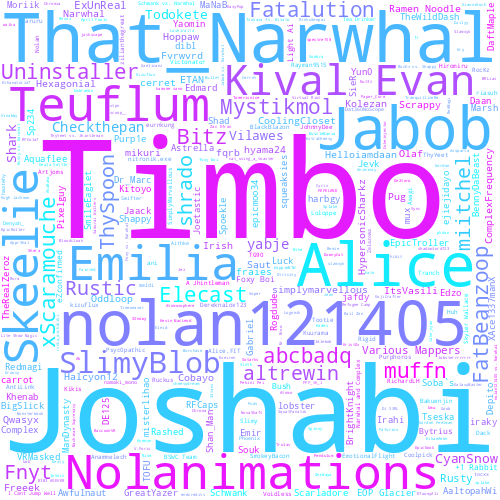

### [Ranked] MyBSCloud - LevelAuthor - weighted - 2023.04.24 - hatopop

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

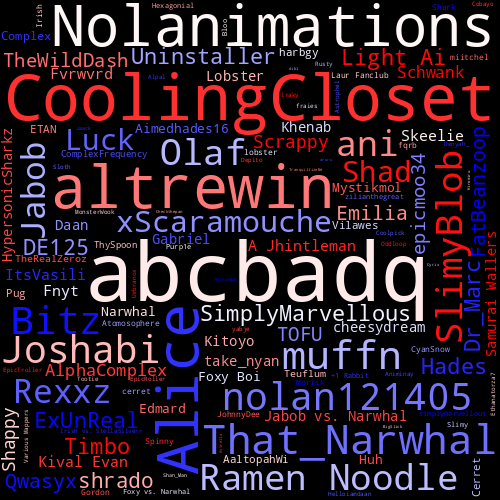

In [3]:
#@title ## MyBSCloud
#@markdown wordcloud_targetはプレイデータの何を対象にwordcloudを作成するかです。LevelAuthor:マッパー、SongAuthor:曲の作者、Song:曲名、マッパー、曲の作者<br >
#@markdown wordの出現頻度の多さでサイズが変わります。<br >
#@markdown max_wordsはワードの数の上限です。小さくすると頻度が少ないワードが消えます。<br >
#@markdown additional_stopwordsは除外したいワードです。本筋と違うけど多く出てきてしまったワードをデフォルトで設定しています。","区切りで必要に応じて追加してください<br >
#@markdown 全体を実行した場合、MyBSCloud(Mask)の画像アップロード待ち状態になり、処理しないと次の処理が動かなくなります。<br >
#@markdown その場合、MyBSCloud(Mask)のキャンセルを実行し、一旦処理を終えてください。<br >

#@markdown ---
#@markdown <h4>Enable</h4>
wordcloud_is_enable = True #@param {type:"boolean"}
download_is_enable = True #@param {type:"boolean"}
#@markdown ---
#@markdown <h4>Setting</h4>

 
width =  500 #@param {type:"number"}
height =  500 #@param {type:"number"}
max_words = 1000#@param {type:"number"}
background_color = "black" #param ["black", "white"]
# wordcloud_target = "Level&SongAuthor" #@param ["All(-Tags)","Level","LevelAuthor", "SongAuthor", "Level&SongAuthor", "Song", "Tags", "All"]
color_map= "bwr" #param['inferno', 'magma', 'plasma', 'viridis','Blues', 'BuGn', 'BuPu', 'GnBu','Greens', 'Greys', 'OrRd', 'Oranges','PuBu', 'PuBuGn', 'PuRd', 'Purples','RdPu', 'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd','binary', 'gist_yarg', 'gist_gray', 'gray','bone', 'pink', 'spring', 'summer','autumn', 'winter', 'cool', 'Wistia','hot', 'afmhot', 'gist_heat', 'copper','PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu','RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic','Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2','Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c','flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'gnuplot','gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv', 'gist_rainbow', 'rainbow','jet', 'nipy_spectral', 'gist_ncar']
wordcloud_style= "normal"  #param["normal","random-icon-style","original-mask"]
additional_stopwords = "feat,ft,Remix,original,TV,Size,Ver,Mix,VS,Video,Game,Movie" #@param {type:"string"}
show_title = False #param {type:"boolean"}

#@markdown ---
#@markdown <h4>Target</h4>
wordcloud_target = "LevelAuthor" #@param ["LevelAuthor", "SongAuthor", "Level&SongAuthor"]
wordcloud_weight_target = "PPWeight" #param ["PP", "PPWeight"]

filtered_level_min = 0 #param {type:"slider", min:0, max:15, step:1}
filtered_level_max = 15 #param {type:"slider", min:0, max:15, step:1}
filtered_pp_min = 0 #param {type:"slider", min:0, max:1000, step:10}
filtered_pp_max = 1000 #param {type:"slider", min:0, max:1000, step:10}
filtered_acc_min = 0 #param {type:"slider", min:0, max:100, step:1}
filtered_acc_max = 100 #param {type:"slider", min:0, max:100, step:1}
filtered_latest_is_enable = False #param {type:"boolean"}
filtered_ranked_is_enable = False #param {type:"boolean"}
filtered_fullcombo_is_enable = False #param {type:"boolean"}

def create_wordcloud(text):
    font_path_gothic = '/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf'
    wordcloud = WordCloud(
                        background_color="white",
                        max_words=max_words,
                        width=width, height=height,
                        # mask=img_color,
                        collocations=False,  # 単語の重複しないように
                        colormap="cool"#"tab20"#"flag"#olor_map
                          ).generate(text)

    # WordCloudの画像をPIL.Imageオブジェクトに変換
    wc_image = wordcloud.to_image()

    # 画像を保存
    output_filename = "MyBSCloud_{}_{}.png".format(tz_ja.strftime("%Y%m%d_%H%M%S"), df_info["name"][0])

    wc_image.save(output_filename)

    # 画像をダウンロード
    if download_is_enable:
        files.download(output_filename)

    # PIL.Imageオブジェクトを表示
    wc_image.show()

def create_weighted_wordcloud(weights, mode="weighted", bg_clr="black", clr_map="bwr"):
    font_path_gothic = '/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf'


    # STOPWORDSを適用して辞書を更新
    filtered_weights = remove_stopwords_from_frequencies(weights)

    # 重み付けを指定してワードクラウドを生成
    wordcloud = WordCloud(
                        background_color=bg_clr, 
                          max_words=max_words, 
                          width=width, height=height,
                          collocations = False,
                          colormap=clr_map
                        ).generate_from_frequencies(filtered_weights)

    # WordCloudの画像をPIL.Imageオブジェクトに変換
    wc_image = wordcloud.to_image()

    # 画像を保存
    output_filename = "MyBSCloud_{}_{}_{}.png".format(mode, tz_ja.strftime("%Y%m%d_%H%M%S"), df_info["name"][0])

    wc_image.save(output_filename)

    # 画像をダウンロード
    if download_is_enable:
        files.download(output_filename)

    # PIL.Imageオブジェクトを表示
    wc_image.show()

# colormap参考記事
# https://karupoimou.hatenablog.com/entry/2019/05/17/153207

df_wordcloud = df_scores.copy()

# ランク用
df_wordcloud_ranked = df_wordcloud.copy()
df_wordcloud_ranked = df_wordcloud_ranked[(df_wordcloud_ranked['Ranked']==1)]
df_wordcloud_ranked = df_wordcloud_ranked[(1==1)
    & (df_wordcloud_ranked["Stars"] >= filtered_level_min)
    & (df_wordcloud_ranked["Stars"] < filtered_level_max)
    & (df_wordcloud_ranked["PP"] >= filtered_pp_min)
    & (df_wordcloud_ranked["PP"] < filtered_pp_max)
    & (df_wordcloud_ranked["Acc"] >= filtered_acc_min)
    & (df_wordcloud_ranked["Acc"] <= filtered_acc_max)]
df_wordcloud_ranked['PPWeightRounded'] = df_wordcloud_ranked['PPWeight'].apply(lambda x: round(float(x), 1))

weights = get_wordcloud_weight(wordcloud_target, df_wordcloud_ranked)

if len(df_wordcloud) > 0 and wordcloud_is_enable:
    # 既存のストップワードに追加するストップワードをカンマで分割
    additional_stopwords_list = additional_stopwords.split(',')

    # ストップワードを追加
    for word in additional_stopwords_list:
        stripped_word = word.strip()
        if stripped_word:  # 空の文字列でない場合にのみ追加
            STOPWORDS.add(stripped_word)


    display(Markdown("""### MyBSCloud - {} - counted - {} - {}""".format(wordcloud_target, tz_ja.strftime("%Y.%m.%d"), df_info["name"][0])))

    counts = get_wordcloud_weight(wordcloud_target, df_wordcloud, True)
    create_weighted_wordcloud(counts, mode="counteed", bg_clr="white", clr_map="cool")

    # create_wordcloud(wc_text)
    display(Markdown("""### [Ranked] MyBSCloud - {} - weighted - {} - {}""".format(wordcloud_target, tz_ja.strftime("%Y.%m.%d"), df_info["name"][0])))
    # print("""\n[Ranked]MyBSCloud-PPweighted-{}-{}""".format(tz_ja.strftime("%Y.%m.%d"), df_info["name"][0]))
    weights = get_wordcloud_weight(wordcloud_target, df_wordcloud_ranked)
    create_weighted_wordcloud(weights)


else:
    print("データ件数が0件または フラグが無効のため WordCloud が作成できません。作成する場合は条件を見直してください。")


<IPython.core.display.Javascript object>

マスク画像ファイルをアップロードしてください（キャンセルで前回のファイルを使用）:


前回アップロードされたファイル 'mask.png' を使用します。


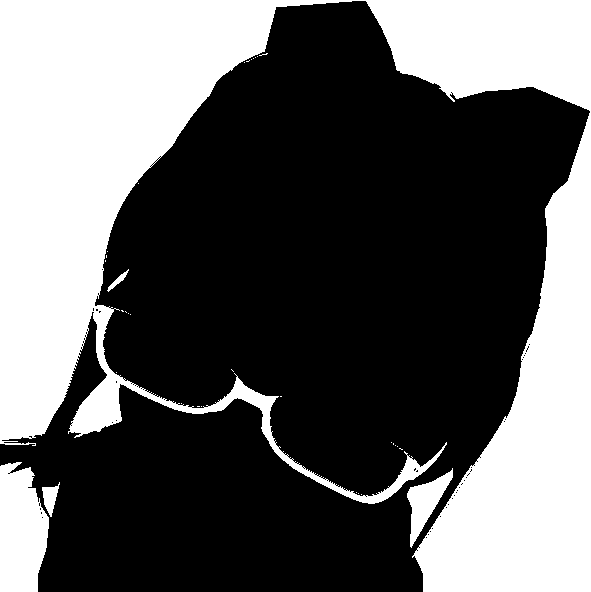

### MyBSCloud(Mask) - LevelAuthor - counted - 2023.04.24 - hatopop

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

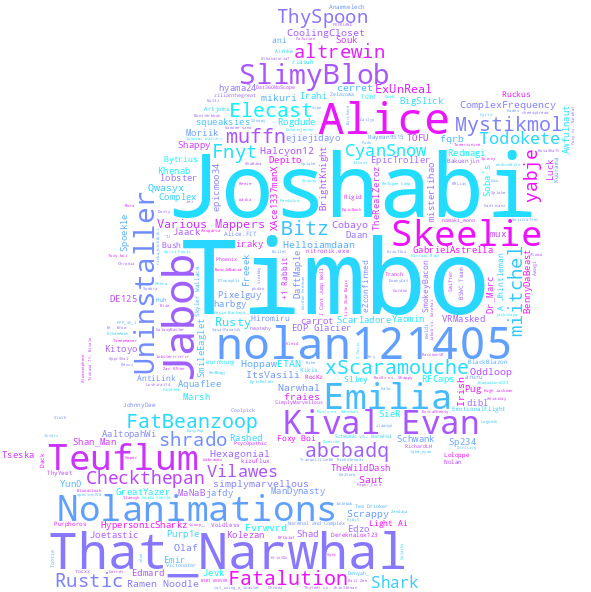

### [Ranked] MyBSCloud(Mask) - LevelAuthor - weighted - 2023.04.24 - hatopop

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

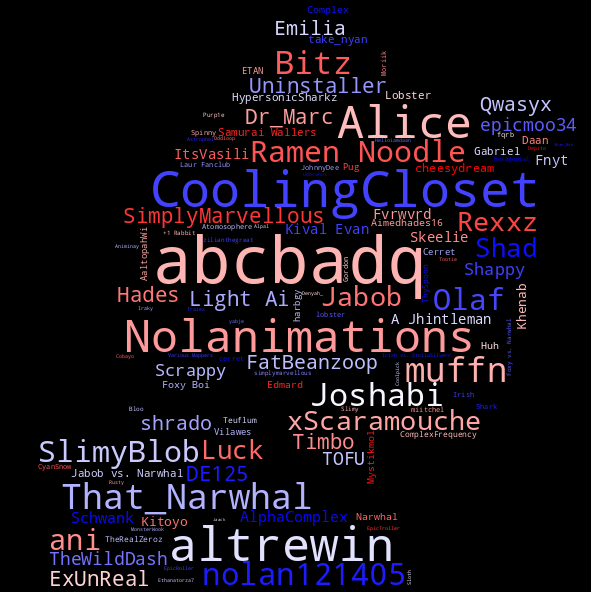

In [8]:
#@title ## MyBSCloud(Mask)

#@markdown ※ デフォルト値(wordcloud_masked_is_enable)を無効にしています。使用する場合は有効にしてください。<br >
#@markdown ※ mask画像のアップロードが必要です。2回目以降キャンセルを押すと前回のmask画像を流用します。<br >
#@markdown 　mask画像は完全な白と黒の画像をアップしてください。マスク画像の黒の部分にwordを出現させます。<br >
#@markdown 　mask画像は白黒ですが、画像はRGBまたはRGBAの形式にしてください。<br >
#@markdown 　mask画像はbinarize_is_enableを有効にすると2値化(白と黒にする)を実行してRGBA形式のマスク画像にしますが、質が低いです。<br >
#@markdown 　thresholdで2値化の閾値を変更可能にしていますが、あまり期待しないでください。(自動でセグメンテーションもためしましたが質が低かったです。<br >
#@markdown 　2値化に背景透過画像を入力として用いる場合、透過部が黒として扱われてしまうので注意してください。<br >
#@markdown 　invert_is_enableを有効にするとマスク画像の白黒を反転した結果を出力します。<br >
#@markdown 　アップロードしたmask画像や出力画像は一時的にcolab上に保存されますがアップロードされますが、セッションを閉じると破棄されます。<br >
#@markdown 　出力画像サイズはmask画像のサイズにup_scaleの倍率をかけたサイズで出力します。<br >
#@markdown 　画像処理の時間は当たり前ですが、処理サイズに応じて大きくなるので注意してください。<br >
#@markdown 　全体を実行した場合など、MyBSCloud(Mask)の画像アップロード待ち状態になり、なんらかの処理をしないと次の処理が動かなくなります。<br >
#@markdown 　その場合、MyBSCloud(Mask)のキャンセルを実行し、一旦処理を終えてください。<br >

#@markdown ---
#@markdown <h4>Enable</h4>
wordcloud_masked_is_enable = False #@param {type:"boolean"}
download_is_enable = True #@param {type:"boolean"}
#@title マスク画像の白黒反転
invert_is_enable = False #@param {type:"boolean"}

#@markdown ---
#@markdown <h4>Setting</h4>
up_scale = 1 #@param {type:"slider", min:0.25, max:4, step:0.25}

max_words =  1000#@param {type:"number"}

background_color = "black" #param ["black", "white"]
# wordcloud_target = "Level&SongAuthor" #@param ["All(-Tags)","Level","LevelAuthor", "SongAuthor", "Level&SongAuthor", "Song", "Tags", "All"]
color_map= "bwr" #param['inferno', 'magma', 'plasma', 'viridis','Blues', 'BuGn', 'BuPu', 'GnBu','Greens', 'Greys', 'OrRd', 'Oranges','PuBu', 'PuBuGn', 'PuRd', 'Purples','RdPu', 'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd','binary', 'gist_yarg', 'gist_gray', 'gray','bone', 'pink', 'spring', 'summer','autumn', 'winter', 'cool', 'Wistia','hot', 'afmhot', 'gist_heat', 'copper','PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu','RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic','Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2','Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c','flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'gnuplot','gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv', 'gist_rainbow', 'rainbow','jet', 'nipy_spectral', 'gist_ncar']
wordcloud_style= "original-mask"  #param["normal","random-icon-style","original-mask"]
additional_stopwords = "feat,ft,Remix,original,TV,Size,Ver,Mix,VS,Video,Game,Movie" #@param {type:"string"}
mask_file_name = "mask.png" #param ["mask.png", "mask_face.png"] {allow-input: true}
show_title = False #param {type:"boolean"}

#@markdown ---
#@markdown <h4>binarize</h4>
binarize_is_enable = True #@param {type:"boolean"}
binarize_threshold =125 #@param {type:"slider", min:1, max:254, step:1}

#@markdown ---
filtered_latest_is_enable = False #param {type:"boolean"}
filtered_fullcombo_is_enable = False #param {type:"boolean"}

#@markdown <h4>Target</h4>
filtered_ranked_is_enable = False #param {type:"boolean"}

filtered_level_min = 0 #param {type:"slider", min:0, max:15, step:1}
filtered_level_max = 15 #param {type:"slider", min:0, max:15, step:1}
filtered_pp_min = 0 #param {type:"slider", min:0, max:1000, step:10}
filtered_pp_max = 1000 #param {type:"slider", min:0, max:1000, step:10}
filtered_acc_min = 0 #param {type:"slider", min:0, max:100, step:1}
filtered_acc_max = 100 #param {type:"slider", min:0, max:100, step:1}
wordcloud_target = "LevelAuthor" #@param ["LevelAuthor", "SongAuthor", "Level&SongAuthor"]

# max_data =  5000#param {type:"number"}
sort_type = "PP" #param ["PP", "Stars", "Acc"] {allow-input: true}

def create_wordcloud_original_mask(text, img_path, invert_is_enable=False):
    font_path_gothic = '/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf'
    img = Image.open(img_path)
    width, height = img.size
    width, height =  math.floor(width * up_scale),  math.floor(height * up_scale)
    img_resized = img.resize((width, height))  # 画像をリサイズ
    img_color = np.array(img_resized)  # リサイズされた画像を配列に変換

    # フラグがTrueの場合、マスク画像の色を反転
    if invert_is_enable:
        img_color = np.invert(img_color)

    # print(img_color.shape)
   
    wordcloud = WordCloud(background_color="white",
                max_words=max_words, 
                width=width, 
                height=height,
                max_font_size=200,  # 最大フォントサイズを設定
                mask=img_color,
                collocations=False, # 単語の重複しないように
                colormap="cool"
                ).generate(text)

    # WordCloudの画像をPIL.Imageオブジェクトに変換
    wc_image = wordcloud.to_image()

    # 画像を保存
    if invert_is_enable:
        output_filename = "MyBSCloud_mask_{}_{}.png".format(tz_ja.strftime("%Y%m%d_%H%M%S"), df_info["name"][0])
    else:
        output_filename = "MyBSCloud_mask_inv_{}_{}.png".format(tz_ja.strftime("%Y%m%d_%H%M%S"), df_info["name"][0])

    wc_image.save(output_filename)

    # 画像をダウンロード
    if download_is_enable:
        files.download(output_filename)

    # PIL.Imageオブジェクトを表示
    wc_image.show()

def create_weighted_wordcloud_original_mask(weights, img_path, invert_is_enable=False, mode="weighted", bg_clr="black", clr_map="bwr"):
    font_path_gothic = '/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf'
    img = Image.open(img_path)
    width, height = img.size
    width, height =  math.floor(width * up_scale),  math.floor(height * up_scale)
    img_resized = img.resize((width, height))  # 画像をリサイズ
    img_color = np.array(img_resized)  # リサイズされた画像を配列に変換

    # フラグがTrueの場合、マスク画像の色を反転
    if invert_is_enable:
        img_color = np.invert(img_color)

    # print(img_color.shape)
   
    # 重み付けを指定してワードクラウドを生成
    wordcloud = WordCloud(background_color=bg_clr,
                        max_words=max_words,
                        width=width, height=height,
                        mask=img_color,
                        collocations=False,  # 単語の重複しないように
                        colormap=clr_map
                        ).generate_from_frequencies(weights)

    # WordCloudの画像をPIL.Imageオブジェクトに変換
    wc_image = wordcloud.to_image()

    # 画像を保存
    if invert_is_enable:
        output_filename = "MyBSCloud_mask_{}_{}_{}.png".format(mode,tz_ja.strftime("%Y%m%d_%H%M%S"), df_info["name"][0])
    else:
        output_filename = "MyBSCloud_mask_{}_inv_{}_{}.png".format(mode,tz_ja.strftime("%Y%m%d_%H%M%S"), df_info["name"][0])

    wc_image.save(output_filename)

    # 画像をダウンロード
    if download_is_enable:
        files.download(output_filename)

    # PIL.Imageオブジェクトを表示
    wc_image.show()

def binarize_image(img, threshold=128):
    # 画像をグレースケールに変換
    img_gray = img.convert('L')
    # 2値化処理
    img_binary = img_gray.point(lambda x: 0 if x < threshold else 255, '1')
    return img_binary

def create_binarize_image(img_path):
    img = Image.open(img_path)

    # 2値化処理
    img_binary = binarize_image(img)

    # 画像をRGBAに変換
    rgba_img = img_binary.convert('RGBA')

    # RGBA画像を保存
    rgba_img.save('rgba_image.png')

    # PIL.Imageオブジェクトを表示
    rgba_img.show()
    mask_image_path = "rgba_image.png"
    return mask_image_path

# colormap参考記事
# https://karupoimou.hatenablog.com/entry/2019/05/17/153207

df_wordcloud = df_scores.copy()

# ランク用
df_wordcloud_ranked = df_wordcloud.copy()
df_wordcloud_ranked = df_wordcloud_ranked[(df_wordcloud_ranked['Ranked']==1)]
df_wordcloud_ranked = df_wordcloud_ranked[(1==1)
    & (df_wordcloud_ranked["Stars"] >= filtered_level_min)
    & (df_wordcloud_ranked["Stars"] < filtered_level_max)
    & (df_wordcloud_ranked["PP"] >= filtered_pp_min)
    & (df_wordcloud_ranked["PP"] < filtered_pp_max)
    & (df_wordcloud_ranked["Acc"] >= filtered_acc_min)
    & (df_wordcloud_ranked["Acc"] <= filtered_acc_max)]
df_wordcloud_ranked['PPWeightRounded'] = df_wordcloud_ranked['PPWeight'].apply(lambda x: round(float(x), 1))
df_wordcloud_ranked = df_wordcloud_ranked.sort_values(sort_type, ascending=False)
# df_wordcloud_ranked = df_wordcloud_ranked[:max_data]

counts = get_wordcloud_weight(wordcloud_target, df_wordcloud, True)
weights = get_wordcloud_weight(wordcloud_target, df_wordcloud_ranked)

if len(df_wordcloud) > 0 and wordcloud_masked_is_enable:
    # 既存のストップワードに追加するストップワードをカンマで分割
    additional_stopwords_list = additional_stopwords.split(',')

    # ストップワードを追加
    for word in additional_stopwords_list:
        stripped_word = word.strip()
        if stripped_word:  # 空の文字列でない場合にのみ追加
            STOPWORDS.add(stripped_word)

    wc_text = get_wordcloud_text(wordcloud_target)

    print("マスク画像ファイルをアップロードしてください（キャンセルで前回のファイルを使用）:")
    from google.colab import files

    # previous_uploaded_file = None
    uploaded = files.upload()

    def process_uploaded_file(file_name, counts, weights, binarize_is_enable, invert_is_enable):
        if binarize_is_enable:
            file_name = create_binarize_image(file_name)

        display(Markdown("""### MyBSCloud(Mask) - {} - counted - {} - {}""".format(wordcloud_target, tz_ja.strftime("%Y.%m.%d"), df_info["name"][0])))
        # print(f"MyBSCloud(mask)-Counted-{tz_ja.strftime('%Y.%m.%d')}-{df_info['name'][0]}")
        # create_wordcloud_original_mask(wc_text, file_name, invert_is_enable)
        create_weighted_wordcloud_original_mask(counts, file_name, invert_is_enable, mode="counted", bg_clr="white", clr_map="cool")

        display(Markdown("""### [Ranked] MyBSCloud(Mask) - {} - weighted - {} - {}""".format(wordcloud_target, tz_ja.strftime("%Y.%m.%d"), df_info["name"][0])))
        # print(f"\n[Ranked]MyBSCloud(mask)-PPweighted-{tz_ja.strftime('%Y.%m.%d')}-{df_info['name'][0]}")
        create_weighted_wordcloud_original_mask(weights, file_name, invert_is_enable)


    if not uploaded:  # アップロードがキャンセルされた場合
        if previous_uploaded_file is not None:
            print(f"前回アップロードされたファイル '{previous_uploaded_file}' を使用します。")
            # process_uploaded_file(previous_uploaded_file, wc_text, weights, binarize_is_enable, invert_is_enable)
            process_uploaded_file(previous_uploaded_file, counts, weights, binarize_is_enable, invert_is_enable)
        else:
            print("アップロードがキャンセルされました。")
    else:  # アップロードが成功した場合
        file_name = next(iter(uploaded))

        previous_uploaded_file = file_name
        # 既存のファイルがある場合は削除
        if os.path.exists(file_name):
            os.remove(file_name)
        # アップロードされたファイルを保存
        with open(file_name, 'wb') as f:
            f.write(uploaded[file_name])
        print(f"アップロードされたファイル名: {file_name}")
        # process_uploaded_file(file_name, wc_text, weights, binarize_is_enable, invert_is_enable)
        process_uploaded_file(file_name, counts, weights, binarize_is_enable, invert_is_enable)

else:
    print("データ件数が0件または フラグが無効のため WordCloud が作成できません。作成する場合は条件を見直してください。")


# データの要約

データ要約の説明<br>

ChatGPT APIを使用したデータ要約のお遊び機能です。その他の関連性は考慮せず、マッパーの頻度値、Weight、アーティストの頻度値、Weightの上位n件を入力として評価結果を取得します。これは流行に乗ったお遊び機能です。

※※※免責事項※※※

この機能を利用するには、有効なOpenAIのAPIキーが必要です。モデルとして"gpt-3.5-turbo"を使用します。APIキーやAPIキーを含むnotebookファイルを絶対に共有しないでください！APIキーが流出した場合、作者は責任を負いかねますので、自己責任でご利用ください。

無償枠を超えてAPIを使用する場合、OpenAI側に課金が発生しますが、作者は責任を負いかねますので、自己責任でご利用ください。1回あたりの課金額は、トータルトークン数 × モデルの1トークンあたりの価格が目安ですが、実際の価格については作者は責任を負いかねますので、自己責任でご利用ください。

->OpenAI課金額: https://platform.openai.com/account/usage

In [17]:
#@title ## 要約
gpt_is_enable = False #@param {type:"boolean"}
openai_key = "" #@param {type:"string"}
top_n = 20 #@param {type:"number"}
model = "gpt-3.5-turbo" #@param ["gpt-3.5-turbo"] {allow-input: true}
MAX_TOKEN = 2048 #@param {type:"number"}

try:
    import openai
except:
    !pip install openai==0.27.0
    import openai

openai.api_key = openai_key

def completion(new_message_text:str, settings_text:str = '', past_messages:list = []):
    if len(past_messages) == 0 and len(settings_text) != 0:
        system = {"role": "system", "content": settings_text}
        past_messages.append(system)
    new_message = {"role": "user", "content": new_message_text}
    past_messages.append(new_message)

    result = openai.ChatCompletion.create(
        model=model,
        messages=past_messages,
        max_tokens=MAX_TOKEN
    )
    response_message = {"role": "assistant", "content": result.choices[0].message.content}
    past_messages.append(response_message)
    response_message_text = result.choices[0].message.content
    prompt_token = result["usage"]["prompt_tokens"]
    total_token = result["usage"]["total_tokens"]
    finish_reason = result.choices[0].finish_reason
    return response_message_text, past_messages, prompt_token, total_token

from heapq import nlargest

def get_top_n(data, n):
    data_int = {k: math.floor(v) for k, v in data.items()}
    top_n = dict(nlargest(n, data_int.items(), key=lambda item: item[1]))
    return top_n

# 翻訳
counts_mapper = get_wordcloud_weight("LevelAuthor", df_wordcloud, True)
weights_mapper = get_wordcloud_weight("LevelAuthor", df_wordcloud_ranked)

counts_artist = get_wordcloud_weight("SongAuthor", df_wordcloud, True)
weights_artist = get_wordcloud_weight("SongAuthor", df_wordcloud_ranked)

counts_mapper_dict = get_top_n(counts_mapper, top_n)
weights_mapper_dict = get_top_n(weights_mapper, top_n)

counts_artist_dict = get_top_n(counts_artist, top_n)
weights_artist_dict = get_top_n(weights_artist, top_n)

if len(openai_key) > 0 and gpt_is_enable:
    system_settings = "与データに対して、プレイヤーの分析を行い、評価結果を返してください。player: player名\nmapper_counts: {'mapperA':'頻度数値A','mapperB':'頻度数値B',...}\nmapper_weights: {'mapperA':'スコアA','mapperB':'B',...}\nartist_counts: {'artistA':'頻度数値A','artistB':'頻度数値B',...}\nartist_weights: {'artistA':'スコアA','artistB':'B',...}\nマークダウン形式で総合評価レポートとして出力してください。\n## 分析結果\n### 0. プレイヤー名(player名)\n### 1. プレイするのに好みのmapper(表形式 top5)\n### 2. PPを食べるのに好みのmapper(表形式 top5)\n### 3. 共通して好みと言えるmapper(表形式 top3)\n### 4. プレイするのに好みのartist(表形式 top5)\n### 5. PPを食べるのに好みのartist(表形式 top5)\n### 6. 共通して好みと言えるartist(表形式 top3)\n### 7. まとめ(1～6の要約と、総合した所見を出力してください。)"

    prompt_text = f"""プレイヤーの統計情報がこちらにあります。mapper_countsはプレイしたmapperの譜面数降順で、mapper_weightsはランク譜面のうちmapper事のPPweightの合計値の降順です。artists_countsはプレイしたartistの譜面数降順で、artists_weightsはランク譜面のうちartist事のPPweightの合計値の降順です。全て上位{top_n}を抽出したデータです。共通するmapper, artistもあると思います。player: {df_info["name"][0]} mapper_counts: {counts_mapper_dict} mapper_weights: {weights_mapper_dict} artist_counts: {counts_artist_dict} artist_weights: {weights_artist_dict}\n"""

    print("分析を開始します...")

    response_text, _, prompt_token, total_token = completion(prompt_text, system_settings, past_messages = [])
    # print(response_text)
    print(f"""分析が完了しました
    prompt token:{prompt_token}
    total token:{total_token}
    """)
    display(Markdown("""---"""))
    display(Markdown(response_text))
else:
    print("GPT機能が有効ではないので、データの概略のみ出力します。")
    print("所見が必要な場合はGPT機能を有効にしてください。")

    def display_dataframe_from_dict(dictionary, key="key", val="val"):
        # dataframe = pd.DataFrame(list(dictionary.items()), columns=['Key', 'Value'])
        dataframe = pd.DataFrame(list(dictionary.items()), columns=[key, val])
        display(dataframe[:5])

    display(Markdown("---"))
    display(Markdown("## 概略"))
    display(Markdown(f"#### Player: {df_info['name'][0]}"))

    display(Markdown("#### プレイするのに好みのmapper(top5)"))
    display_dataframe_from_dict(counts_mapper_dict, 'Mapper', 'Count')

    display(Markdown("#### PPを食べるのに好みのmapper(top5)"))
    display_dataframe_from_dict(weights_mapper_dict, 'Mapper', '"Weight')

    display(Markdown("#### プレイするのに好みのartist(top5)"))
    display_dataframe_from_dict(counts_artist_dict,'Artist', 'Count')

    display(Markdown("####  PPを食べるのに好みのartist(top5)"))
    display_dataframe_from_dict(weights_artist_dict,'Artist','Weight')


<IPython.core.display.Javascript object>

GPT機能が有効ではないので、データの概略のみ出力します。
所見が必要な場合はGPT機能を有効にしてください。


---

## 概略

#### Player: hatopop

#### プレイするのに好みのmapper(top5)

,Mapper,Count
0,Timbo,133
1,Joshabi,106
2,That_Narwhal,103
3,nolan121405,81
4,Alice,77


#### PPを食べるのに好みのmapper(top5)

,Mapper,"""Weight"
0,abcbadq,857
1,CoolingCloset,586
2,altrewin,520
3,Alice,476
4,Nolanimations,471


#### プレイするのに好みのartist(top5)

,Artist,Count
0,Camellia,209
1,Kobaryo,90
2,USAO,71
3,t+pazolite,62
4,Laur,54


####  PPを食べるのに好みのartist(top5)

,Artist,Weight
0,Camellia,1005
1,Massive New Krew,534
2,MY FIRST STORY,390
3,Shiggy Jr.,336
4,USAO,327
